# Demo of Pairwise Clustering

Let's take a look at a problem where pairwise clustering is a natural fit as a solution.

Consider two datasets which contain information about researchers and their work. The datasets have significant overlap so that one record in one dataset and one record in the other actually refer to the same researcher. For some of the researchers it is trivial to match them because their orcid, a unique identifier, is available. However, for the vast majority of records the orcid is not available.

Let's conduct some basic data analysis on these datasets so that we can craft a similarity score to feed into our pairwise clustering function.

This is the structure of the data in the two datasets
| Column name | Type |
| ------------ | --- |
| id | Categorical |
| first_name | Categorical |
| middle_name | Categorical |
| lastname | Categorical |
| coinvestigator_lastnames/coauthor_lastnames | Variable length categorical array |
| topics | Variable length categorical array |
| cities | Variable length categorical key-value pair array |
| countries | Variable length categorical key-value pair array |
| orcid | Categorical |

orcid and id will only be used in evaluation and output of the approaches, respectively (not as inputs to the algorithms)

Let's load the data

In [1]:
import pandas as pd
df_investigators = pd.read_csv('./investigator.csv', encoding='latin-1')
df_investigators.columns = list(range(df_investigators.shape[1]))
df_authors = pd.read_csv('./author.csv', encoding='latin-1')
df_authors.columns = list(range(df_authors.shape[1]))
df_input = pd.concat([df_authors, df_investigators], axis=0)
df_input = df_input.reset_index()
# creating 2d list of topics
topics_element_arr = df_input[5]
topics_arr = [eval(topic) for topic in topics_element_arr]
# creating 2d list of cities
cities_element_arr = df_input[6]
cities_dict_arr = [eval(city.replace("null", "None")) for city in cities_element_arr]
cities_arr = [[city_dict['identifier'] for city_dict in city_list] for city_list in cities_dict_arr]
# creating 2d list of countries
countries_element_arr = df_input[7]
countries_dict_arr = [eval(country.replace("null", "None")) for country in countries_element_arr]
countries_arr = [[country_dict['identifier'] for country_dict in country_list] for country_list in countries_dict_arr]

## Exploring the data
By briefly looking at the data, it seems that the following rules apply to the first name, middle name, and last name of matching instances
* The last name must match exactly
* If the first name is NA or missing for either one, then nothing has to match; If one only has a first initial and the other has the full first name, the first character of the first name must match the other first initial; otherwise, the first name must match exactly
* If the middle name is NA or missing for either one, then nothing has to match; if one only has the middle initial and the other has the full middle name, the first character of the middle name must match the other middle initial; otherwise, the middle name must match exactly

Names which contain periods have their periods removed, as this is not part of the name

Let's see if our hypotheses hold by testing them on known matching instances

In [2]:
for i in range(1019, len(df_input[0])): # number of records in investigator dataset
  for a in range(1019): # number of records in author dataset
    last = True
    middle = True
    first = True
    # if these are matching instances
    if df_input[8][i] == df_input[8][a] and not pd.isna(df_input[8][i]):
      # if the last names do not exactly match
      if not df_input[3][i] == df_input[3][a]:
        last = False
      # if these are non-NaN values
      investigator_first = df_input[1][i]
      author_first = df_input[1][a]
      if not pd.isna(investigator_first) and not pd.isna(author_first):
        if investigator_first.find('.') >= 0:
          investigator_first = investigator_first.replace('.','')
        if author_first.find('.') >= 0:
          author_first = author_first.replace('.','')
        if len(author_first) > 0 and len(investigator_first) > 0:
          # if the length of either the investigator or author first name is 1
          if len(investigator_first) == 1 or len(author_first) == 1:
            # if the first characters of the first names do not match
            if not investigator_first[0] == author_first[0]:
              first = False
          elif len(investigator_first) > 1 and len(author_first) > 1:
            # if the first names do not match
            if not investigator_first == author_first:
              first = False
      # if these are non-NaN values
      investigator_middle = df_input[2][i]
      author_middle = df_input[2][a]
      if not pd.isna(investigator_middle) and not pd.isna(author_middle):
        if investigator_middle.find('.') >= 0:
          investigator_middle = investigator_middle.replace('.','')
        if author_middle.find('.') >= 0:
          author_middle = author_middle.replace('.','')
        if len(author_middle) > 0 and len(investigator_middle) > 0:
          # if the length of either the investigator or author middle name is 1
          if len(investigator_middle) == 1 or len(author_middle) == 1:
            # if the first characters of the middle names do not match
            if not investigator_middle[0] == author_middle[0]:
              middle = False
          elif len(investigator_middle) > 1 and len(author_middle) > 1:
            # if the middle names do not match
            if not investigator_middle == author_middle:
              middle = False
    # if any of the first, middle, or last names do not match as described
    # print "not a match"
    if not (first and middle and last):
      print("not a match")


We set up the code in the previous cell to output "not a match" for any records which are in fact matching on their orcids but according to our hypotheses were not a match. Because the previous cell produced no output, our hypothesis seems to be vindicated.

Let us now see how other features related in matching instances. Let's first examine how often country and city are the same in matching instances.

In [3]:
countries_percentages = []
cities_percentages = []
for i in range(1019, len(df_input[0])):
  for a in range(1019):
    # if these are matching instances
    if df_input[8][i] == df_input[8][a] and not pd.isna(df_input[8][i]):
      true_count = 0
      # check if all the countries in the investigator array are in the author array and vice versa
      set_i = set(countries_arr[i])
      set_a = set(countries_arr[a])
      inv_intersection = set_i.intersection(set_a)
      auth_intersection = set_a.intersection(set_i)
      countries_percentages.append(len(inv_intersection)/len(set_i) if len(set_i) > 0 else 1)
      countries_percentages.append(len(auth_intersection)/len(set_a) if len(set_a) > 0 else 1)

      # check if all the cities in the investigator array are in the author array and vice versa
      set_i = set(cities_arr[i])
      set_a = set(cities_arr[a])
      inv_intersection = set_i.intersection(set_a)
      auth_intersection = set_a.intersection(set_i)
      cities_percentages.append(len(inv_intersection)/len(set_i) if len(set_i) > 0 else 1)
      cities_percentages.append(len(auth_intersection)/len(set_a) if len(set_a) > 0 else 1)

print("countries fractions: " + str(countries_percentages))
print("cities fractions: " + str(cities_percentages))

countries fractions: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

The first array in the output contains the fraction of countries in the investigator array that are also in the author array and vice versa

The second one contains the percentages of how many of the cities in the investigator array are in the author array and vice versa

We can see that both arrays contains only 1s, which means that the countries and cities of matching instances are always exact matches in the dataset

Let us now calculate what we did above for non-matching instances

In [4]:
import numpy as np
countries_percentages = []
cities_percentages = []
for i in range(1019, len(df_input[0])):
  for a in range(1019):
    # if these are not matching instances
    if df_input[8][i] != df_input[8][a] or pd.isna(df_input[8][i]) or pd.isna(df_input[8][a]):
      set_i = set(countries_arr[i])
      set_a = set(countries_arr[a])
      inv_intersection = set_i.intersection(set_a)
      auth_intersection = set_a.intersection(set_i)
      countries_percentages.append(len(inv_intersection)/len(set_i) if len(set_i) > 0 else 1)
      countries_percentages.append(len(auth_intersection)/len(set_a) if len(set_a) > 0 else 1)

      set_i = set(cities_arr[i])
      set_a = set(cities_arr[a])
      inv_intersection = set_i.intersection(set_a)
      auth_intersection = set_a.intersection(set_i)
      cities_percentages.append(len(inv_intersection)/len(set_i) if len(set_i) > 0 else 1)
      cities_percentages.append(len(auth_intersection)/len(set_a) if len(set_a) > 0 else 1)

print("average countries fractions: " + str(np.mean(countries_percentages)))
print("std dev of countries fractions: " + str(np.std(countries_percentages)))
print("average cities fractions: " + str(np.mean(cities_percentages)))
print("std dev of cities fractions: " + str(np.std(cities_percentages)))

average countries fractions: 0.2801483187490761
std dev of countries fractions: 0.4456790177770279
average cities fractions: 0.25013502622129996
std dev of cities fractions: 0.43263697312408295


The first two values are the average and standard deviation, respectively, of the fractions of how many of the countries in the investigator array are in the author array and vice versa

The last two values are the average and standard deviation, respectively, of the fractions of how many of the cities in the investigator array are in the author array and vice versa

The average values tell us that around a quarter of the countries/cities overlap between the authors and investigators in non-matching cases, however the std dev values tell us that there is significant variation here and that it wouldn't be impossible for us to see high or even exact overlap in non-matching instances.

Before moving forward, let's set aside coauthors/coinvestigators and note that from a brief visual check they don't seem to give us much information in matching/non-matching cases and therefore we won't use them in constructing the similarity score.

The story is different for topics. There does seem to be some overlap in topics in matching cases. One intuition here is to build a term frequency matrix to record distinct topics and the frequency with which these appear with other topics. This could help us construct the similarity score for topics. However, this approach would be greatly inefficient. There are other NLP approaches we could use here but the simplest one for now would be to approach it the same way we did coauthors/coinvestigators.

In [5]:
topics_percentages = []
for i in range(1019, len(df_input[0])):
  for a in range(1019):
    # if these are matching instances
    if df_input[8][i] == df_input[8][a] and not pd.isna(df_input[8][i]):
      set_i = set(topics_arr[i])
      set_a = set(topics_arr[a])
      inv_intersection = set_i.intersection(set_a)
      auth_intersection = set_a.intersection(set_i)
      topics_percentages.append(len(inv_intersection)/len(set_i) if len(set_i) > 0 else 1)
      topics_percentages.append(len(auth_intersection)/len(set_a) if len(set_a) > 0 else 1)

print("mean topics percentage: " + str(np.mean(topics_percentages)))
print("std dev of topics percentages: " + str(np.std(topics_percentages)))

mean topics percentage: 0.3207805839695993
std dev of topics percentages: 0.3819204427734216


We can see from the output above that, on average, around a third of the topics of matching authors/investigators instances overlap. There is significant variability. Let us now compare this with the average for non-matching instances.

In [6]:
topics_percentages = []
for i in range(1019, len(df_input[0])):
  for a in range(1019):
    # if these are matching instances
    if df_input[8][i] != df_input[8][a] or pd.isna(df_input[8][i]) or pd.isna(df_input[8][a]):
      set_i = set(topics_arr[i])
      set_a = set(topics_arr[a])
      inv_intersection = set_i.intersection(set_a)
      auth_intersection = set_a.intersection(set_i)
      topics_percentages.append(len(inv_intersection)/len(set_i) if len(set_i) > 0 else 1)
      topics_percentages.append(len(auth_intersection)/len(set_a) if len(set_a) > 0 else 1)

print("mean topics percentage: " + str(np.mean(topics_percentages)))
print("std dev of topics percentages: " + str(np.std(topics_percentages)))

mean topics percentage: 0.1365303513605662
std dev of topics percentages: 0.2616279973136567


We can see from the output above that, on average, around 14% of the topics of non-matching authors/investigators instances overlap. There is once again significant variability, albeit slightly lower than for matching instances.
This tells us that matching instances contain, on average, 2.5x as many matching topics as non-matching instances and that this is a good method of differentiating between non-matching and matching instances.


# Proposed Solution
Let us take a look at why we need our pairwise clustering algorithm. Consider the example below.

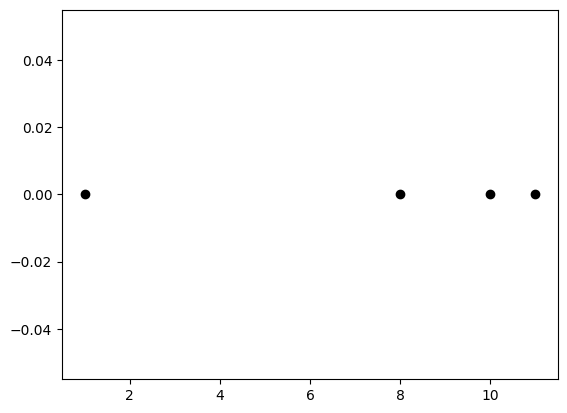

In [7]:
import matplotlib.pyplot as plt
x = [1, 8, 10, 11]
y = [0, 0, 0, 0]
plt.plot(x, y, 'o', color='black')

If we use k-means clustering here and set k to 2, the three rightmost points would typically cluster together and the leftmost point would be in its own cluster. So, we need clusters of a fixed size not a fixed number of clusters.

Now that we have discussed that, let's get to designing our similarity score which we will feed into the pairwise clustering algorithm implemented in pairwise_clustering() in pairwise_clustering.py.

For the similarity metric, we must consider how much weight to give to names, countries, cities, and topics.

Because the score from countries, cities, and topics falls in the same scale (0-1), the scale need not be changed.

We will give countries/cities 1.6x as much weight as countries and cities because:

As calculated above, topics tells us that matching instances, on average, have a value 2.5x as as high as non-matching instances while cities and countries tell us that matching instances, on average, have a value 4x as high as non-matching instances. These are all very rough calculations and can be made more rigorous as needed. This means that topics is (4/2.5)=1.6x as informative as countries or cities.

We will assign a negative infinity similarity score to those instances which do not match the naming rules we laid out at the beginning of this investigation. In addition to this, we will calculate a score for names that do match those rules.
For now, let's consider middle names more informative than first names because fewer people have them, and therefore give them a higher weight.
As a heuristic for names, which could later be improved:

If the first names are both longer than 1 character and match exactly, the name score is incremented by 0.4

Else if one of them is only one character and they both match, the name score is incremented by 0.2

If the middle names are both longer than 1 character and match exactly, the name score is incremented by 0.6

Else if one of them is only one character and they both match, the name score is incremented by 0.3

Our similarity score between two instances x and y can be represented as follows:

sim(x,y) =

$\delta_m + \delta_n + \frac{1}{2}(\frac{1}{c_x}\sum_{j=1}^{c_x}f_{j,x,c} + \frac{1}{c_y}\sum_{j=1}^{c_y}f_{j,y,c}) + \frac{1}{2}(\frac{1}{u_x}\sum_{j=1}^{u_x}f_{j,x,u} + \frac{1}{u_y}\sum_{j=1}^{u_y}f_{j,y,u}) + 1.2(\frac{1}{t_x}\sum_{j=1}^{t_x}f_{j,x,t} + \frac{1}{t_y}\sum_{j=1}^{t_y}f_{j,y,t})$  

where

$f_{j,y,e} = 1 $ if $x_{e_j} \in y_e$, $f_{j,y,e} = 0 $ if $x_{e_j} \notin y_e$  
$f_{j,x,e} = 1 $ if $y_{e_j} \in x_e$, $f_{j,x,e} = 0 $ if $y_{e_j} \notin x_e$  

The above are used to calculate overlap

$\delta_e = 0.6$ if $e = m$ and $x_e = y_e$, $\delta_e = 0.3$ if $e = m$ and $x_e[0] = y_e[0]$  
$\delta_e = 0.4$ if $e = n$ and $x_e = y_e$, $\delta_e = 0.2$ if $e = n$ and $x_e[0] = y_e[0]$  

The above are used to calculate the name score

e in the equation above represents the different features of x and y
* e = {m, n, c, u, t} = {middle name, first name, list of cities, list of cities, list of topics}

Let's load the data from the csvs in a way that's going to be easily compatible with the similarity score and the pairwise clustering functions.

In [8]:
from dataclasses import dataclass
from typing import List

@dataclass
class Researcher:
    id: str
    first_name: str
    middle_name: str
    last_name: str
    topics: List[str]
    cities: List[str]
    countries: List[str]
    orcid: str

def row_to_researcher(row):
    topics_list = eval(row[5].replace("null", "None"))
    cities_list = [city_dict['identifier'] for city_dict in eval(row[6].replace("null", "None"))]
    countries_list = [country_dict['identifier'] for country_dict in eval(row[7].replace("null", "None"))]
    if pd.isna(row[1]):
        first_name = ""
    else:
        first_name = row[1].replace(".", "")
    if pd.isna(row[2]):
        middle_name = ""
    else:
        middle_name = row[2].replace(".", "")

    return Researcher(
        id=row[0],
        first_name=first_name,
        middle_name=middle_name,
        last_name=row[3],
        topics=topics_list,
        cities=cities_list,
        countries=countries_list,
        orcid=row[8]
    )

investigators = df_investigators.apply(row_to_researcher, axis=1).tolist()
authors = df_authors.apply(row_to_researcher, axis=1).tolist()

Let's implement the similarity score in code.

In [9]:
def researcher_similarity_score(researcher1: Researcher, researcher2: Researcher) -> float:
    country_score, city_score, topic_score, name_score = 0, 0, 0, 0

    if researcher1.last_name != researcher2.last_name:
        return float('-inf')
    r1_first_len = len(researcher1.first_name)
    r2_first_len = len(researcher2.first_name)
    r1_middle_len = len(researcher1.middle_name)
    r2_middle_len = len(researcher2.middle_name)
    if r1_first_len > 1 and r2_first_len > 1:
        if researcher1.first_name == researcher2.first_name:
            name_score += 0.4
        else:
            return float('-inf')
    elif (r1_first_len == 1 or r2_first_len == 1) and r1_first_len + r2_first_len >= 2:
        if researcher1.first_name[0] == researcher2.first_name[0]:
            name_score += 0.2
        else:
            return float('-inf')
    if r1_middle_len > 1 and r2_middle_len > 1:
        if researcher1.middle_name == researcher2.middle_name:
            name_score += 0.6
        else:
            return float('-inf')
    elif (r1_middle_len == 1 or r2_middle_len == 1) and r1_middle_len + r2_middle_len >= 2:
        if researcher1.middle_name[0] == researcher2.middle_name[0]:
            name_score += 0.3
        else:
            return float('-inf')
    country_set1 = set(researcher1.countries)
    country_set2 = set(researcher2.countries)
    country_intersection = country_set1.intersection(country_set2)
    country_union = country_set1.union(country_set2)
    country_score = len(country_intersection)/len(country_union) if len(country_union) > 0 else 0
    city_set1 = set(researcher1.cities)
    city_set2 = set(researcher2.cities)
    city_intersection = city_set1.intersection(city_set2)
    city_union = city_set1.union(city_set2)
    city_score = len(city_intersection)/len(city_union) if len(city_union) > 0 else 0
    topic_set1 = set(researcher1.topics)
    topic_set2 = set(researcher2.topics)
    topic_intersection = topic_set1.intersection(topic_set2)
    topic_union = topic_set1.union(topic_set2)
    topic_score = len(topic_intersection)/len(topic_union) if len(topic_union) > 0 else 0

    return country_score + city_score + topic_score + name_score


In [10]:
from pairwise_clustering import pairwise_clustering

matches = pairwise_clustering(investigators, authors, researcher_similarity_score)

The matching objects from both lists are in matches. Let's see what percent of actually matching instances (which we know through orcid) we get correct.

In [11]:
actual_matches = []
for investigator in investigators:
    for author in authors:
        if investigator.orcid == author.orcid:
            actual_matches.append((investigator.orcid, author.orcid))
matches_ids = [(r1.orcid, r2.orcid) for r1, r2 in matches]
num_correct = 0
for m in matches_ids:
    if m in actual_matches:
        num_correct += 1

print(f"{num_correct/len(actual_matches)*100}% accuracy")


98.05825242718447% accuracy


Even with a low number of runs, the algorithm almost always achieves 97%+ accuracy. As the number of runs increases, the accuracy tends upwards. The algorithm has a worst case time complexity of $O(kn^2)$ wrt input k runs and a maximum of n instances in either of the input lists. Despite the quadratic complexity, we can see here it's very fast with relatively small inputs.